In [201]:
import pandas as pd
import numpy as np
import glob
import seaborn as sn
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima import model
from statsmodels.regression import linear_model
from pmdarima.arima import auto_arima
from scipy import signal
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [202]:
#Import data
med_file = r"C:\Users\mlaws\OneDrive - Western Governors University\Documents\WGU\D213\medical_time_series .csv"
data = pd.read_csv(med_file)

In [203]:
# Exploratory data analysis. 
data.shape

(731, 2)

In [204]:
# Visualize data. 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [205]:
# Search for nulls.
data.isnull().sum()

Day        0
Revenue    0
dtype: int64

In [206]:
# View first five rows of data
data.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [207]:
# Convert 'Day' to DateTime format
data['Date'] = (pd.date_range(start=pd.datetime(2019, 1, 1),
            periods=data.shape[0], freq='24H'))
# Set the Date as an index
data.set_index('Date',inplace=True)
data

,Day,Revenue
Date,,
2019-01-01,1,0.000000
2019-01-02,2,-0.292356
2019-01-03,3,-0.327772
2019-01-04,4,-0.339987
2019-01-05,5,-0.124888
...,...,...
2020-12-27,727,15.722056
2020-12-28,728,15.865822
2020-12-29,729,15.708988


In [208]:
# Check index dtype
data.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=731, freq=None)

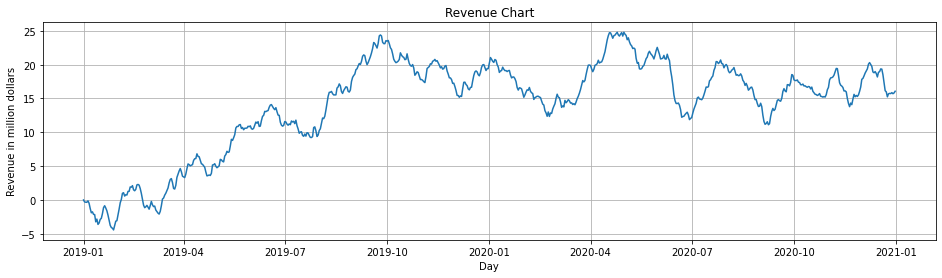

In [209]:
# Visualize data on line graph
plt.figure(figsize=(16,4))
plt.plot(data['Revenue'])
plt.title('Revenue Chart')
plt.xlabel('Day')
plt.ylabel('Revenue in million dollars')
plt.grid(True)
plt.show()

In [210]:
# Run ADFuller test to check if data is stationary
result = adfuller(data['Revenue'])
print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

Test statistics:  -2.2183190476089485
p-value:  0.19966400615064228
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [211]:
if result[1]<= 0.05:
    print("The time series is stationary. Reject the null hypothesis.")
else:
    print("The time series is non-stationary. Fail to reject null hypothesis.")

The time series is non-stationary. Fail to reject null hypothesis.


In [212]:
# Make the data stationary
df_stationary = data.diff().dropna()

In [213]:
st_result = adfuller(df_stationary['Revenue'])

In [214]:
print("test statistics: ", st_result[0])
print("p-value: ", st_result[1])
print("critical values: ", st_result[4])

test statistics:  -17.37477230355706
p-value:  5.1132069788403175e-30
critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [215]:
if st_result[1]<= 0.05:
    print("The time series is stationary. Reject the null hypothesis.")
else:
    print("The time series is non-stationary.Fail to reject null hypothesis.")

The time series is stationary. Reject the null hypothesis.


In [216]:
# Export copy of cleaned data set
pd.DataFrame(df_stationary).to_csv(r"C:\Users\mlaws\OneDrive - Western Governors University\Documents\WGU\D213\medical_time_series_cleaned.csv")

<Figure size 1152x288 with 0 Axes>

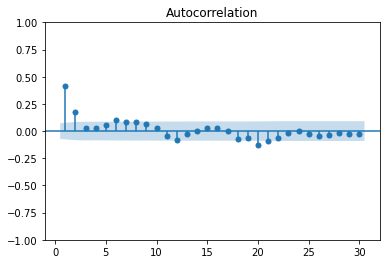

In [217]:
# Plot ACF on the stationary data
plt.figure(figsize=(16,4))
X = df_stationary['Revenue']
y = df_stationary['Day']

plot_acf(X, lags=30, zero=False)
plt.show()

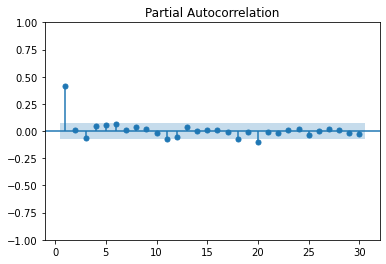

In [218]:
# Plot PACF
plot_pacf(X, lags=30, zero=False)
plt.show()

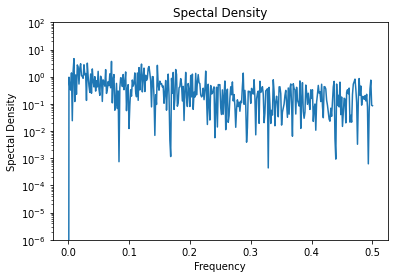

In [219]:
# Plot spectral density
f, Pxx_den = signal.periodogram(df_stationary['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectal Density')
plt.xlabel('Frequency')
plt.ylabel('Spectal Density')
plt.show()

In [220]:
# Split the data into train/test sets
X_train = data.loc[:'2020-09-30']
X_test = data.loc['2020-10-01':]
print('X_train Shape', X_train.shape)
print('X_test Shape', X_test.shape)

X_train Shape (639, 2)
X_test Shape (92, 2)


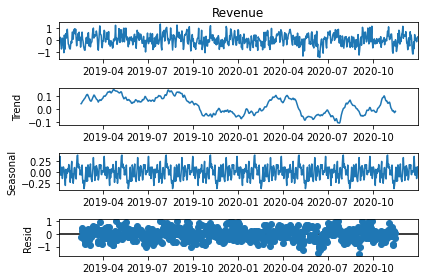

In [221]:
# Decompose Time Series
decomp = seasonal_decompose(df_stationary['Revenue'], period=90)
# Plot decomposition
decomp.plot()
# Check  for seasonality in the data
plt.show() 

<AxesSubplot:title={'center':'Seasonality'}, xlabel='Date'>

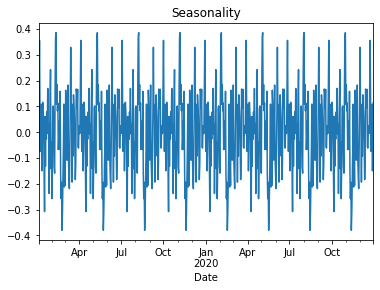

In [222]:
# Plot the Seasonality
plt.title('Seasonality')
decomp.seasonal.plot()

<AxesSubplot:title={'center':'Trend'}, xlabel='Date'>

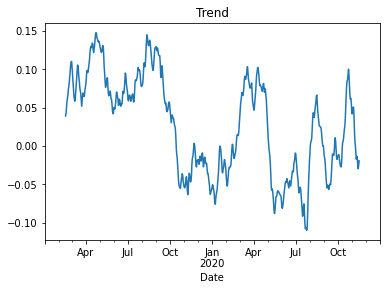

In [223]:
# Plot the trend
plt.title('Trend')
decomp.trend.plot()

<AxesSubplot:title={'center':'Residuals'}, xlabel='Date'>

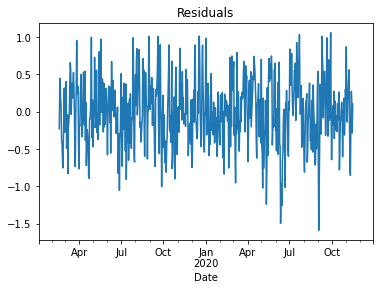

In [224]:
# Plot the residuals
plt.title('Residuals')
decomp.resid.plot()

In [225]:
# Run Auto-Arima to discover the best p,q & d fit for the model
model = auto_arima(X_train['Revenue'], start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=782.952, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=895.175, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=780.955, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=801.272, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=895.419, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=782.951, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=782.178, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=779.867, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=781.858, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=781.860, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=800.680, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=781.053, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.934 seconds


In [226]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  639
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -387.933
Date:                Sun, 18 Sep 2022   AIC                            779.867
Time:                        22:20:30   BIC                            788.784
Sample:                    01-01-2019   HQIC                           783.328
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4100      0.037     11.194      0.000       0.338       0.482
sigma2         0.1975      0.012     16.543      0.000       0.174       0.221
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.94   Prob(JB):                         0.35
Heteroskedasticity (H):               1.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [232]:
# Forecast
prediction, confint = model.predict(n_periods=92, return_conf_int=True)
prediction

2020-10-01    18.382233
2020-10-02    18.364138
2020-10-03    18.356718
2020-10-04    18.353677
2020-10-05    18.352430
                ...    
2020-12-27    18.351563
2020-12-28    18.351563
2020-12-29    18.351563
2020-12-30    18.351563
2020-12-31    18.351563
Freq: D, Length: 92, dtype: float64

In [233]:
cf= pd.DataFrame(confint)

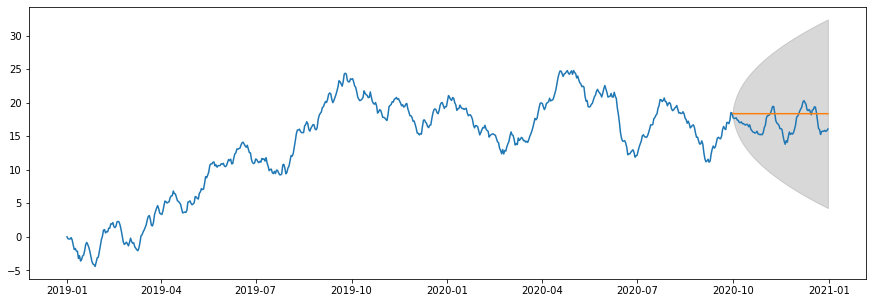

In [234]:
prediction_series = pd.Series(prediction,index=X_test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data['Revenue'])
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

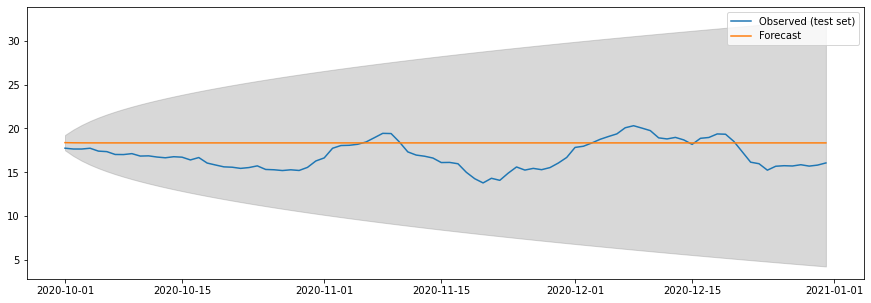

In [235]:
# Prediction data zoomed in
prediction_series = pd.Series(prediction,index=X_test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data['Revenue']['2020-10-01':], label='Observed (test set)')
ax.plot(prediction_series, label='Forecast')
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
plt.legend()

In [236]:
# Create function for symmetric mean absolute percentage error (SMAPE)
def calcsmape(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))

In [197]:
# Calculate SMAPE
smape=calcsmape(X_test.Revenue,prediction)
print('Symmetric Mean Absolute Percentage Error (SMAPE): ', smape)

Symmetric Mean Absolute Percentage Error (SMAPE):  0.3044051602894103
